# Advanced Machine Learning Models in PySpark

This notebook implements multiple classification models using PySpark with random search hyperparameter optimization.

## Table of Contents
1. [Model Selection Configuration](#1.-Model-Selection-Configuration)
2. [Importing Libraries](#2.-Importing-Libraries)
3. [Loading and Preprocessing Data](#3.-Loading-and-Preprocessing-Data)
4. [Helper Functions](#4.-Helper-Functions)
    - [4.1 Random Search Function](#4.1-Random-Search-Function)
    - [4.2 Evaluation Functions](#4.2-Evaluation-Functions)
5. [Model Training](#5.-Model-Training)
    - [5.1 Logistic Regression](#5.1-Logistic-Regression)
    - [5.2 Random Forest](#5.2-Random-Forest)
    - [5.3 Gradient Boosted Trees](#5.3-Gradient-Boosted-Trees-(GBDT))
    - [5.4 Multilayer Perceptron](#5.4-Multilayer-Perceptron-(MLP))
6. [Model Comparison](#6.-Model-Comparison)
7. [Test Set Evaluation](#7.-Test-Set-Evaluation-with-Best-Model)
8. [Conclusion](#8.-Conclusion)

## 1. Model Selection Configuration

**Set to True for models you want to train, False for models to skip.**

In [0]:
# Model selection configuration - Set to True to run, False to skip
RUN_MODELS = {
    'logistic_regression': True,
    'random_forest': False,
    'gbdt': False,
    'mlp': False
}

# Random search configuration
RANDOM_SEARCH_CONFIG = {
    'num_folds': 3,      # Number of folds for cross-validation
    'parallelism': 1     # Number of parallel tasks during tuning
}

# File paths configuration
DATA_PATHS = {
    'train': "dbfs:/FileStore/tables/train_df.csv",
    'val': "dbfs:/FileStore/tables/val_df.csv",
    'test': "dbfs:/FileStore/tables/test_df.csv"
}

## 2. Importing Libraries

In [0]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from math import ceil
import time

# PySpark imports
from pyspark.sql import SparkSession  
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, when, lit, count, lag, expr

# ML imports for classification
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics

# Scikit-learn imports for metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Initialize Spark session
spark = SparkSession.builder.appName("ML Models Spark").getOrCreate()

## 3. Loading and Preprocessing Data

In [0]:
def load_and_preprocess_data(file_paths):
    """Load and preprocess data from specified file paths.
    
    Args:
        file_paths (dict): Dictionary with keys 'train', 'val', 'test' and file path values
        
    Returns:
        tuple: Preprocessed train, validation, and test data
    """
    # Load data
    train_data = spark.read.csv(file_paths['train'], header=True, inferSchema=True)
    val_data = spark.read.csv(file_paths['val'], header=True, inferSchema=True)
    test_data = spark.read.csv(file_paths['test'], header=True, inferSchema=True)
    
    # Select feature columns (all except 'label', 'time', and 'file')
    feature_cols = [col for col in train_data.columns if col not in ['label', 'time', 'file']]
    
    # Assemble features into a single vector column
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    train_data = assembler.transform(train_data).select("features", "label")
    val_data = assembler.transform(val_data).select("features", "label")
    test_data = assembler.transform(test_data).select("features", "label")
    
    print(f"Data loaded and preprocessed:")
    print(f"  - Training samples: {train_data.count()}")
    print(f"  - Validation samples: {val_data.count()}")
    print(f"  - Test samples: {test_data.count()}")
    
    return train_data, val_data, test_data

# Load and preprocess the data
train_data, val_data, test_data = load_and_preprocess_data(DATA_PATHS)

# Display a few samples
print("\nSample of training data:")
train_data.show(3)

# Count classes
num_classes = train_data.select("label").distinct().count()
print(f"\nNumber of classes: {num_classes}")

Data loaded and preprocessed:
  - Training samples: 3142910
  - Validation samples: 681381
  - Test samples: 681395

Sample of training data:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-1.611721611721E...|    0|
|[1.95360195360194...|    0|
|[-9.7680097680097...|    0|
+--------------------+-----+
only showing top 3 rows


Number of classes: 3


## 4. Helper Functions

### 4.1 Random Search Function

In [0]:
def perform_random_search(model, param_grid, train_data, val_data, num_folds=3, parallelism=2):
    """Perform random search for hyperparameter tuning of a model.
    
    Args:
        model: Machine learning model instance
        param_grid: Parameter grid for random search
        train_data: Training data DataFrame
        val_data: Validation data DataFrame
        num_folds: Number of cross-validation folds
        parallelism: Number of parallel tasks
        
    Returns:
        tuple: (best_model, best_params, train_predictions, val_predictions, train_f1, val_f1)
    """
    # Initialize the evaluator for F1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='f1'
    )
    
    # Initialize CrossValidator for hyperparameter tuning
    cv = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=num_folds,
        parallelism=parallelism
    )
    
    # Start timing
    start_time = time.time()
    
    # Fit the cross-validator to the training data
    print("Training model with random search...")
    cv_model = cv.fit(train_data)
    
    # End timing
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Extract the best model
    best_model = cv_model.bestModel
    
    # Get best parameters
    best_params = {}
    for param in best_model.extractParamMap():
        param_name = param.name
        param_value = best_model.getOrDefault(param)
        best_params[param_name] = param_value
    
    # Make predictions with the best model
    train_predictions = best_model.transform(train_data)
    val_predictions = best_model.transform(val_data)
    
    # Calculate F1 scores
    train_f1 = evaluator.evaluate(train_predictions)
    val_f1 = evaluator.evaluate(val_predictions)
    
    return best_model, best_params, train_predictions, val_predictions, train_f1, val_f1

# Special function for MLP which needs custom random search due to layers parameter
def perform_mlp_random_search(train_data, val_data, num_features, num_classes):
    """Perform custom random search for MLP hyperparameter tuning.
    
    Args:
        train_data: Training data DataFrame
        val_data: Validation data DataFrame
        num_features: Number of input features
        num_classes: Number of classes
        
    Returns:
        tuple: (best_model, best_params, train_predictions, val_predictions, train_f1, val_f1)
    """
    # Initialize the evaluator for F1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', 
        predictionCol='prediction', 
        metricName='f1'
    )
    
    # Define different network architectures for random search
    layers_options = [
        [num_features, num_features, num_classes],  # Simple network
        [num_features, num_features * 2, num_features, num_classes],  # Medium network
        [num_features, num_features * 2, num_features * 2, num_features, num_classes]  # Complex network
    ]
    
    # Define parameter combinations
    block_sizes = [64, 128, 256]
    max_iters = [50, 100, 200]
    learning_rates = [0.01, 0.03, 0.1]
    
    # Track best model and score
    best_mlp_model = None
    best_mlp_val_f1 = 0
    best_mlp_params = {}
    best_train_predictions = None
    best_val_predictions = None
    best_mlp_train_f1 = 0
    
    # Start timing
    start_time = time.time()
    
    print("Training MLP models with random search...")
    total_combinations = len(layers_options) * len(block_sizes) * len(max_iters) * len(learning_rates)
    current_combination = 0
    
    # Manually iterate through parameter combinations
    for layers in layers_options:
        for block_size in block_sizes:
            for max_iter in max_iters:
                for step_size in learning_rates:
                    current_combination += 1
                    print(f"\rTrying combination {current_combination}/{total_combinations}", end="")
                    
                    # Initialize MLP with current parameters
                    mlp = MultilayerPerceptronClassifier(
                        labelCol="label",
                        featuresCol="features",
                        layers=layers,
                        blockSize=block_size,
                        maxIter=max_iter,
                        stepSize=step_size,
                        seed=42
                    )
                    
                    # Train and evaluate the model
                    mlp_model = mlp.fit(train_data)
                    train_predictions = mlp_model.transform(train_data)
                    val_predictions = mlp_model.transform(val_data)
                    mlp_train_f1 = evaluator.evaluate(train_predictions)
                    mlp_val_f1 = evaluator.evaluate(val_predictions)
                    
                    # Update best model if this one is better
                    if mlp_val_f1 > best_mlp_val_f1:
                        best_mlp_val_f1 = mlp_val_f1
                        best_mlp_train_f1 = mlp_train_f1
                        best_mlp_model = mlp_model
                        best_train_predictions = train_predictions
                        best_val_predictions = val_predictions
                        best_mlp_params = {
                            'layers': layers,
                            'blockSize': block_size,
                            'maxIter': max_iter,
                            'stepSize': step_size
                        }
    
    # End timing
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    return best_mlp_model, best_mlp_params, best_train_predictions, best_val_predictions, best_mlp_train_f1, best_mlp_val_f1

### 4.2 Evaluation Functions

In [0]:
# Helper function to convert PySpark predictions to numpy arrays for plotting
def get_prediction_labels(predictions_df):
    """Extract prediction and label columns from PySpark DataFrame."""
    pred_labels = predictions_df.select("prediction", "label").toPandas()
    y_pred = pred_labels["prediction"].values
    y_true = pred_labels["label"].values
    return y_pred, y_true

# Helper function to get prediction probabilities
def get_prediction_probabilities(predictions_df):
    """Extract probability column from PySpark DataFrame."""
    prob_df = predictions_df.select("probability").toPandas()
    return np.array([x.toArray() for x in prob_df["probability"]])

# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix using seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Helper function to print classification report
def print_classification_report(y_true, y_pred):
    """Print classification report with precision, recall, and F1 scores."""
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)

# Helper function to plot ROC curve for multi-class
def plot_roc_curve(y_true, y_pred_proba, n_classes):
    """Plot ROC curve for multi-class classification."""
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Convert to one-hot encoding for ROC calculation
    y_true_onehot = np.zeros((len(y_true), n_classes))
    for i in range(len(y_true)):
        y_true_onehot[i, int(y_true[i])] = 1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, color in zip(range(n_classes), colors[:n_classes]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.
                 format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Return the average AUC
    return np.mean(list(roc_auc.values()))

# Helper function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, n_classes):
    """Plot Precision-Recall curve for multi-class classification."""
    # Compute precision-recall pairs for different probability thresholds
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    # Convert to one-hot encoding
    y_true_onehot = np.zeros((len(y_true), n_classes))
    for i in range(len(y_true)):
        y_true_onehot[i, int(y_true[i])] = 1
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred_proba[:, i])
        avg_precision[i] = np.mean(precision[i])
    
    # Plot precision-recall curve for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, color in zip(range(n_classes), colors[:n_classes]):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='Class {0} (avg precision = {1:0.2f})'.
                 format(i, avg_precision[i]))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()
    
    return np.mean(list(avg_precision.values()))

def evaluate_model(model_name, val_predictions, num_classes, has_probability=True):
    """Perform comprehensive evaluation of a model.
    
    Args:
        model_name: Name of the model
        val_predictions: PySpark DataFrame with predictions
        num_classes: Number of classes
        has_probability: Whether the model outputs probability scores
        
    Returns:
        tuple: (y_pred, y_true, y_pred_proba)
    """
    print(f"\n--- {model_name} Evaluation ---")
    
    # Extract predictions and true labels
    y_pred, y_true = get_prediction_labels(val_predictions)
    
    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_true, y_pred, f"{model_name} Confusion Matrix")
    
    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print_classification_report(y_true, y_pred)
    
    # If model has probability outputs, plot ROC and PR curves
    y_pred_proba = None
    if has_probability:
        y_pred_proba = get_prediction_probabilities(val_predictions)
        
        # Plot ROC curve
        print("\nROC Curve:")
        auc_score = plot_roc_curve(y_true, y_pred_proba, num_classes)
        print(f"{model_name} Average AUC: {auc_score:.4f}")
        
        # Plot Precision-Recall curve
        print("\nPrecision-Recall Curve:")
        avg_precision = plot_precision_recall_curve(y_true, y_pred_proba, num_classes)
        print(f"{model_name} Average Precision: {avg_precision:.4f}")
    
    return y_pred, y_true, y_pred_proba

## 5. Model Training

### 5.1 Logistic Regression


==== Logistic Regression Model ====
Training model with random search...
Training completed in 646.68 seconds

Best Logistic Regression Parameters:
  aggregationDepth: 2
  elasticNetParam: 0.0
  family: auto
  featuresCol: features
  fitIntercept: True
  labelCol: label
  maxBlockSizeInMB: 0.0
  maxIter: 100
  predictionCol: prediction
  probabilityCol: probability
  rawPredictionCol: rawPrediction
  regParam: 0.1
  standardization: True
  threshold: 0.5
  tol: 1e-06

Logistic Regression - Training F1 Score: 0.9064
Logistic Regression - Validation F1 Score: 0.8553

--- Logistic Regression Evaluation ---

Confusion Matrix:


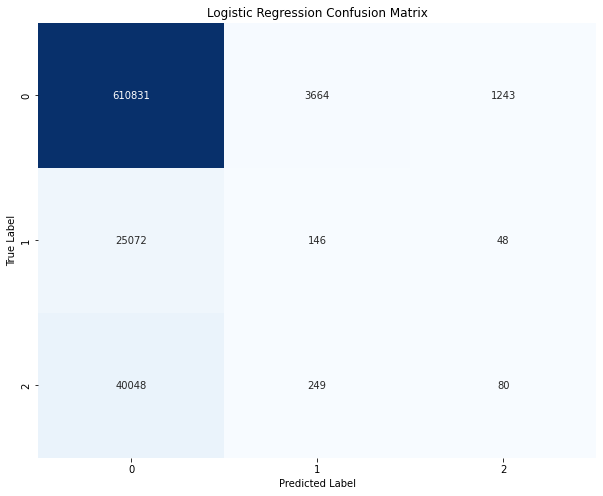


Logistic Regression Classification Report:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95    615738
           1       0.04      0.01      0.01     25266
           2       0.06      0.00      0.00     40377

    accuracy                           0.90    681381
   macro avg       0.33      0.33      0.32    681381
weighted avg       0.82      0.90      0.86    681381



/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



ROC Curve:


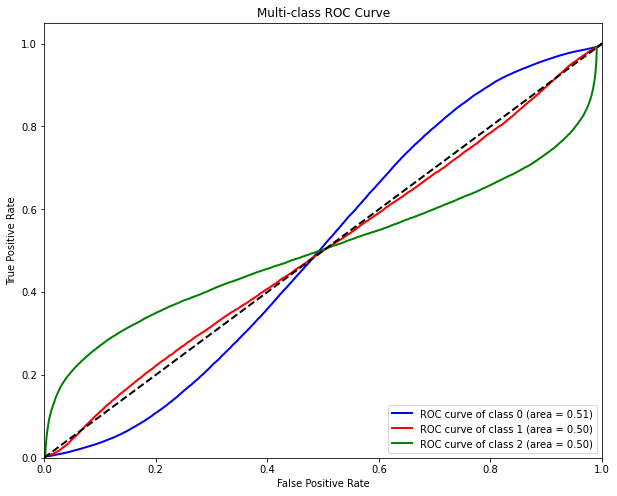

Logistic Regression Average AUC: 0.5037

Precision-Recall Curve:


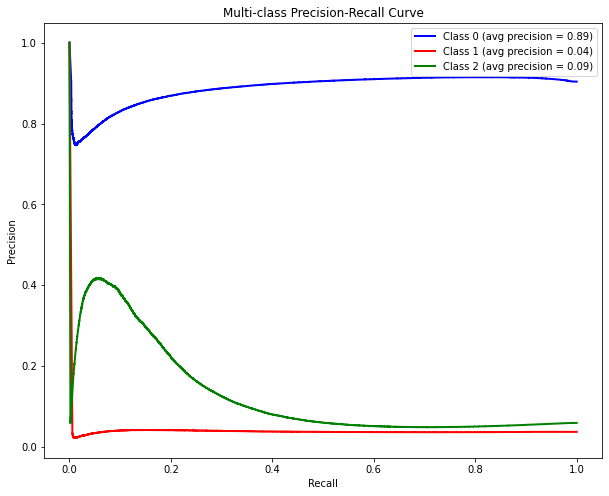

Logistic Regression Average Precision: 0.3365


In [0]:
if RUN_MODELS['logistic_regression']:
    print("\n==== Logistic Regression Model ====")
    
    # Initialize the Logistic Regression model
    log_reg = LogisticRegression(labelCol='label', featuresCol='features', predictionCol='prediction')
    
    # Define the parameter grid for logistic regression
    lr_param_grid = ParamGridBuilder() \
        .addGrid(log_reg.regParam, [0.1]) \
        .addGrid(log_reg.elasticNetParam, [0.0]) \
        .build()
    
    # Perform random search
    lr_best_model, lr_best_params, lr_train_preds, lr_val_preds, lr_train_f1, lr_val_f1 = perform_random_search(
        log_reg, 
        lr_param_grid, 
        train_data, 
        val_data, 
        num_folds=RANDOM_SEARCH_CONFIG['num_folds'],
        parallelism=RANDOM_SEARCH_CONFIG['parallelism']
    )
    
    # Print best parameters and performance
    print("\nBest Logistic Regression Parameters:")
    for param, value in lr_best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nLogistic Regression - Training F1 Score: {lr_train_f1:.4f}")
    print(f"Logistic Regression - Validation F1 Score: {lr_val_f1:.4f}")
    
    # Run comprehensive evaluation
    lr_y_pred, lr_y_true, lr_y_pred_proba = evaluate_model("Logistic Regression", lr_val_preds, num_classes)
else:
    print("Skipping Logistic Regression")

### 5.2 Random Forest

In [0]:
if RUN_MODELS['random_forest']:
    print("\n==== Random Forest Model ====")
    
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(labelCol="label", featuresCol="features")
    
    # Define parameter grid for Random Forest
    rf_param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50, 100, 200]) \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .addGrid(rf.impurity, ["gini", "entropy"]) \
        .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
        .build()
    
    # Perform random search
    rf_best_model, rf_best_params, rf_train_preds, rf_val_preds, rf_train_f1, rf_val_f1 = perform_random_search(
        rf, 
        rf_param_grid, 
        train_data, 
        val_data, 
        num_folds=RANDOM_SEARCH_CONFIG['num_folds'],
        parallelism=RANDOM_SEARCH_CONFIG['parallelism']
    )
    
    # Print best parameters and performance
    print("\nBest Random Forest Parameters:")
    for param, value in rf_best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nRandom Forest - Training F1 Score: {rf_train_f1:.4f}")
    print(f"Random Forest - Validation F1 Score: {rf_val_f1:.4f}")
    
    # Run comprehensive evaluation
    rf_y_pred, rf_y_true, rf_y_pred_proba = evaluate_model("Random Forest", rf_val_preds, num_classes)
else:
    print("Skipping Random Forest")

Skipping Random Forest


### 5.3 Gradient Boosted Trees (GBDT)

In [0]:
if RUN_MODELS['gbdt']:
    print("\n==== Gradient Boosted Trees Model ====")
    
    # Initialize GBT Classifier
    gbt = GBTClassifier(labelCol="label", featuresCol="features")
    
    # Define parameter grid for GBT
    gbt_param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxIter, [10, 20, 50]) \
        .addGrid(gbt.maxDepth, [3, 5, 7]) \
        .addGrid(gbt.stepSize, [0.05, 0.1, 0.2]) \
        .addGrid(gbt.minInstancesPerNode, [1, 2, 4]) \
        .build()
    
    # Perform random search
    gbt_best_model, gbt_best_params, gbt_train_preds, gbt_val_preds, gbt_train_f1, gbt_val_f1 = perform_random_search(
        gbt, 
        gbt_param_grid, 
        train_data, 
        val_data, 
        num_folds=RANDOM_SEARCH_CONFIG['num_folds'],
        parallelism=RANDOM_SEARCH_CONFIG['parallelism']
    )
    
    # Print best parameters and performance
    print("\nBest GBDT Parameters:")
    for param, value in gbt_best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nGBDT - Training F1 Score: {gbt_train_f1:.4f}")
    print(f"GBDT - Validation F1 Score: {gbt_val_f1:.4f}")
    
    # GBT models don't provide probability outputs in Spark
    gbt_y_pred, gbt_y_true, _ = evaluate_model("GBDT", gbt_val_preds, num_classes, has_probability=False)
else:
    print("Skipping GBDT")

Skipping GBDT


### 5.4 Multilayer Perceptron (MLP)

In [0]:
if RUN_MODELS['mlp']:
    print("\n==== Multilayer Perceptron Model ====")
    
    # Get number of features
    num_features = len(train_data.select("features").first()[0])
    
    # Perform custom random search for MLP
    mlp_best_model, mlp_best_params, mlp_train_preds, mlp_val_preds, mlp_train_f1, mlp_val_f1 = perform_mlp_random_search(
        train_data, 
        val_data, 
        num_features, 
        num_classes
    )
    
    # Print best parameters and performance
    print("\nBest MLP Parameters:")
    for param, value in mlp_best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nMLP - Training F1 Score: {mlp_train_f1:.4f}")
    print(f"MLP - Validation F1 Score: {mlp_val_f1:.4f}")
    
    # MLP models don't provide probability outputs in Spark
    mlp_y_pred, mlp_y_true, _ = evaluate_model("MLP", mlp_val_preds, num_classes, has_probability=False)
else:
    print("Skipping MLP")

Skipping MLP


## 6. Model Comparison

Model Performance Comparison:
                 Model  Training F1  Validation F1  Difference (Train-Val)
0  Logistic Regression     0.906386       0.855267                0.051118


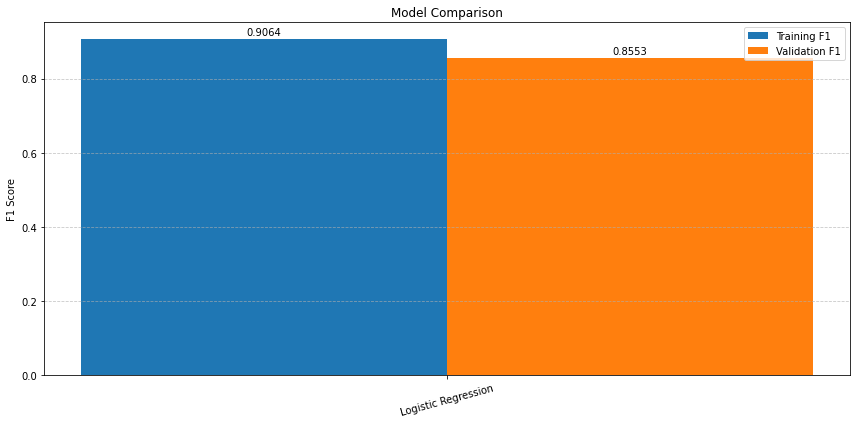

In [0]:
# Collect model names and scores for models that were run
model_names = []
train_scores = []
val_scores = []

if RUN_MODELS['logistic_regression']:
    model_names.append("Logistic Regression")
    train_scores.append(lr_train_f1)
    val_scores.append(lr_val_f1)
    
if RUN_MODELS['random_forest']:
    model_names.append("Random Forest")
    train_scores.append(rf_train_f1)
    val_scores.append(rf_val_f1)
    
if RUN_MODELS['gbdt']:
    model_names.append("GBDT")
    train_scores.append(gbt_train_f1)
    val_scores.append(gbt_val_f1)
    
if RUN_MODELS['mlp']:
    model_names.append("MLP")
    train_scores.append(mlp_train_f1)
    val_scores.append(mlp_val_f1)

# Check if we have any models to compare
if not model_names:
    print("No models were run for comparison.")
else:
    # Create a comparison DataFrame
    model_comparison = pd.DataFrame({
        'Model': model_names,
        'Training F1': train_scores,
        'Validation F1': val_scores,
        'Difference (Train-Val)': [train - val for train, val in zip(train_scores, val_scores)]
    })
    
    print("Model Performance Comparison:")
    print(model_comparison)
    
    # Plot model comparison
    plt.figure(figsize=(12, 6))
    ind = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(ind - width/2, train_scores, width, label='Training F1')
    plt.bar(ind + width/2, val_scores, width, label='Validation F1')
    
    plt.ylabel('F1 Score')
    plt.title('Model Comparison')
    plt.xticks(ind, model_names, rotation=15)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, v in enumerate(train_scores):
        plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')
        
    for i, v in enumerate(val_scores):
        plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()

## 7. Test Set Evaluation with Best Model

Best Model: Logistic Regression with Validation F1: 0.8553
Test F1 Score with Logistic Regression: 0.8004

--- Logistic Regression Test Set Evaluation ---

--- Logistic Regression (Test) Evaluation ---

Confusion Matrix:


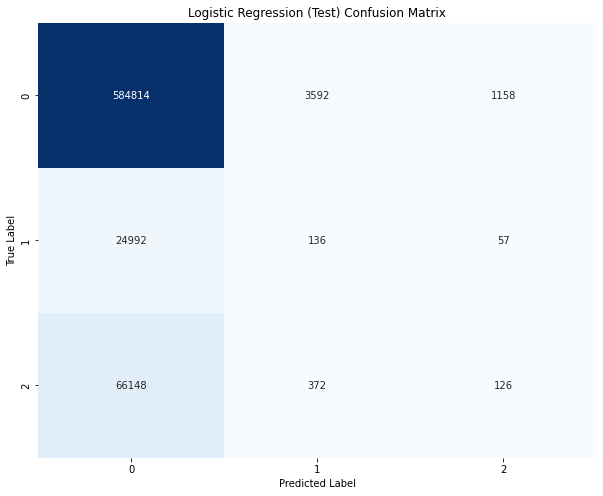


Logistic Regression (Test) Classification Report:
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92    589564
           1       0.03      0.01      0.01     25185
           2       0.09      0.00      0.00     66646

    accuracy                           0.86    681395
   macro avg       0.33      0.33      0.31    681395
weighted avg       0.76      0.86      0.80    681395



/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



ROC Curve:


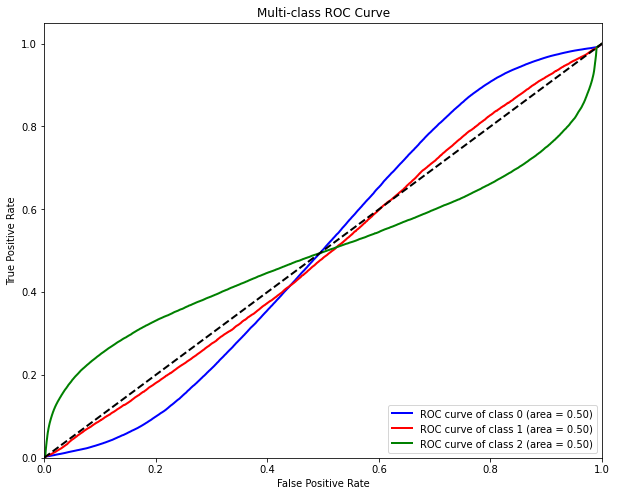

Logistic Regression (Test) Average AUC: 0.4990

Precision-Recall Curve:


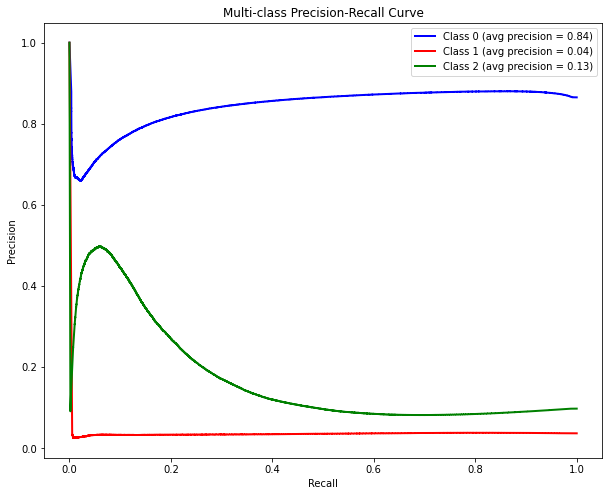

Logistic Regression (Test) Average Precision: 0.3358


In [0]:
if model_names:  # Only run if we have models
    # Find the best model based on validation F1 scores
    best_model_index = val_scores.index(max(val_scores))
    best_model_name = model_names[best_model_index]
    print(f"Best Model: {best_model_name} with Validation F1: {max(val_scores):.4f}")
    
    # Get the corresponding model object
    if best_model_name == "Logistic Regression" and RUN_MODELS['logistic_regression']:
        best_model = lr_best_model
        has_probability = True
    elif best_model_name == "Random Forest" and RUN_MODELS['random_forest']:
        best_model = rf_best_model
        has_probability = True
    elif best_model_name == "GBDT" and RUN_MODELS['gbdt']:
        best_model = gbt_best_model
        has_probability = False
    elif best_model_name == "MLP" and RUN_MODELS['mlp']:
        best_model = mlp_best_model
        has_probability = False
    
    # Make predictions on the test set
    test_predictions = best_model.transform(test_data)
    
    # Initialize the evaluator for F1 score
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
    
    # Evaluate on test set
    test_f1 = evaluator.evaluate(test_predictions)
    print(f"Test F1 Score with {best_model_name}: {test_f1:.4f}")
    
    # Run comprehensive evaluation on test set
    print(f"\n--- {best_model_name} Test Set Evaluation ---")
    test_y_pred, test_y_true, test_y_pred_proba = evaluate_model(
        f"{best_model_name} (Test)", 
        test_predictions, 
        num_classes, 
        has_probability=has_probability
    )
else:
    print("No models were run, skipping test set evaluation.")

## 8. Conclusion

In this notebook, we've implemented a modular framework for training and evaluating multiple classification models using PySpark with random search hyperparameter optimization.

The key features of this framework are:

1. **Flexible Model Selection**: Users can easily select which models to run by setting configuration flags

2. **Modular Design**:
   - Random search functionality is contained in reusable functions
   - Evaluation metrics and visualizations are handled by dedicated functions
   - Each model follows the same workflow structure

3. **Comprehensive Evaluation**:
   - F1 scores for both training and validation data
   - Confusion matrices
   - Detailed classification reports 
   - ROC curves and AUC values (where applicable)
   - Precision-Recall curves (where applicable)

4. **Models Implemented**:
   - Logistic Regression: Tuned for regularization, elastic net mixing, iterations, and model family
   - Random Forest: Optimized for tree count, depth, impurity measure, and min instances per node
   - Gradient Boosted Trees: Fine-tuned for iterations, depth, learning rate, and min instances per node
   - Multilayer Perceptron: Explored different network architectures, block sizes, iterations, and learning rates

This framework makes it easy to run experiments across different machines and with different team members by simply configuring which models to run at the beginning of the notebook.